<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A12_%E9%80%B2%E9%9A%8E%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E6%9D%8E%E6%99%BA%E6%8F%9A/015_GradCAM_PyTorch_0808.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=fa4703720debd10c49ead2dc632a29211851352ab891efca4e4f6cb962b23ca3
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import (
    GradCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM
)
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    preprocess_image
)

from torchvision.models import resnet50
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import torch

#### Class Activation Map

In [ ]:
filepath =  'test.jpg' #'dogcat.png' #'both2.jpeg'
img_size = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#
from torchvision.models import ResNet50_Weights
# Preprocess Transform
transform =  ResNet50_Weights.DEFAULT.transforms()

# # ImageNet transform
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((img_size, img_size)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# select pre-trained model
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
# model = resnet50(pretrained=True).to(device)
model.eval()

# select layer output for visualization
# example:
# Resnet18 and 50: [model.layer4[-1]]
# VGG and densenet161: [model.features[-1]]
# mnasnet1_0: [model.layers[-1]]
target_layer = [model.layer4[-1]]

cam = None

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 315MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def read_img(filepath, img_size=224):
    img = cv2.imread(filepath)[:, :, ::-1]
    img = cv2.resize(img, (img_size, img_size)) # (img_size, img_size, 3)
    return img

In [ ]:
def visualize(img, method, img_size=224, target_category=None):
    # If target_category is None, the highest scoring category
    # will be used for every image in the batch.
    # target_category can also be an integer, or a list of different integers
    # for every image in the batch.

    # Create to torch tensor, add batch dim
    input_tensor = transform(img).unsqueeze(0) # (1, 3, img_size, img_size)

    # Construct the CAM object once, and then re-use it on many images:
    cam = method(model=model, target_layers=target_layer, use_cuda=True)

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor,
                        # target_category=target_category)
                        targets=target_category)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    cam_on_img = show_cam_on_image(img/255., grayscale_cam, use_rgb=True)

    return grayscale_cam, cam_on_img

#### Get class prediction by model

[ImageNet class to name](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

243: 'bull mastiff', 鬥牛獒

254: 'pug, pug-dog', 巴哥犬

282: 'tiger cat', 虎斑貓

242: 'boxer', 拳師犬

281: 'tabby, tabby cat', 虎貓

292: 'tiger, Panthera tigris', 老虎

539: 'doormat, welcome mat', 門墊

In [ ]:
img = read_img(filepath)
img = transform(img).unsqueeze(0).to(device)
pred = model(img)
# convert to probabilities of each classes
pred = torch.nn.Softmax(dim=1)(pred)[0]

print('Top 1 class: ', pred.argmax().item())
values, ids =  torch.topk(pred, k=5)
print('Top 5 class: ', ids.tolist())
print('Top 5 value: ', values.tolist())

Top 1 class:  243
Top 5 class:  [243, 254, 292, 282, 281]
Top 5 value:  [0.7010381817817688, 0.0586380660533905, 0.05400888994336128, 0.033743925392627716, 0.03350771218538284]


#### Visualize single image

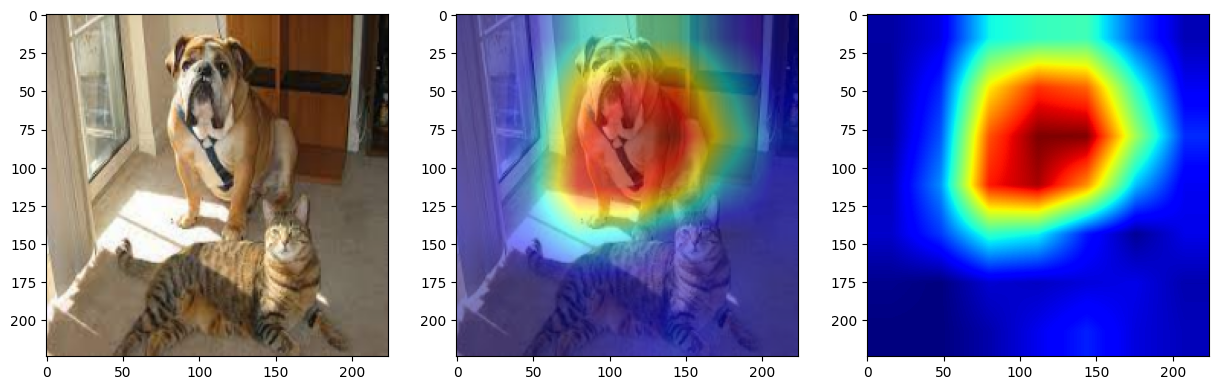

In [ ]:
img = read_img(filepath)
grayscale_cam, cam_on_img = visualize(img.copy(), GradCAM, img_size=img_size,
                                      target_category=None)

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(cam_on_img)
plt.subplot(1, 3, 3)
plt.imshow(grayscale_cam, cmap='jet')
plt.show()

#### Visualize single image with target class

[ImageNet class to name](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

e.g:

242: 'boxer',

243: 'bull mastiff',

282: 'tiger cat',

254: 'pug, pug-dog', 巴哥犬

281: 'tabby, tabby cat',

539: 'doormat, welcome mat',

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

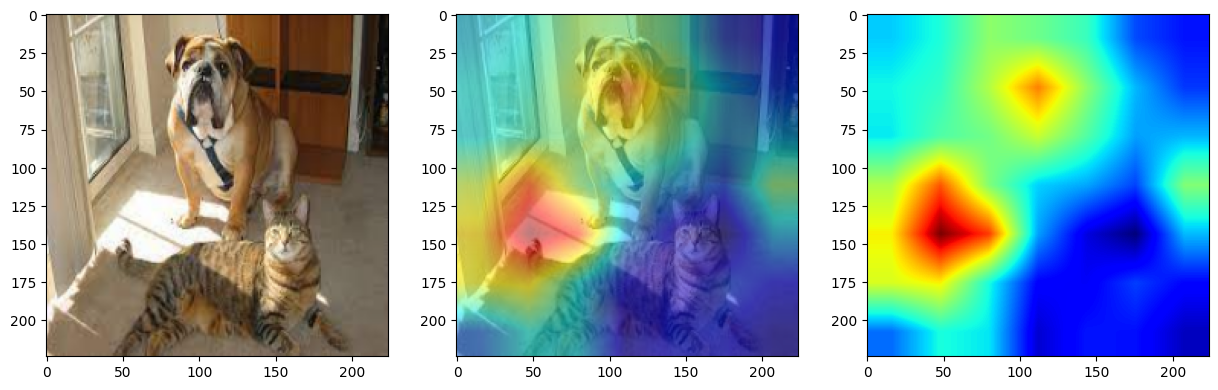

In [ ]:
img = read_img(filepath)
grayscale_cam, cam_on_img = visualize(img.copy(), GradCAM, img_size=img_size,
    target_category=[ClassifierOutputTarget(539)])

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(cam_on_img)
plt.subplot(1, 3, 3)
plt.imshow(grayscale_cam, cmap='jet')
plt.show()

#### Multi-method Visualization

0
1
2


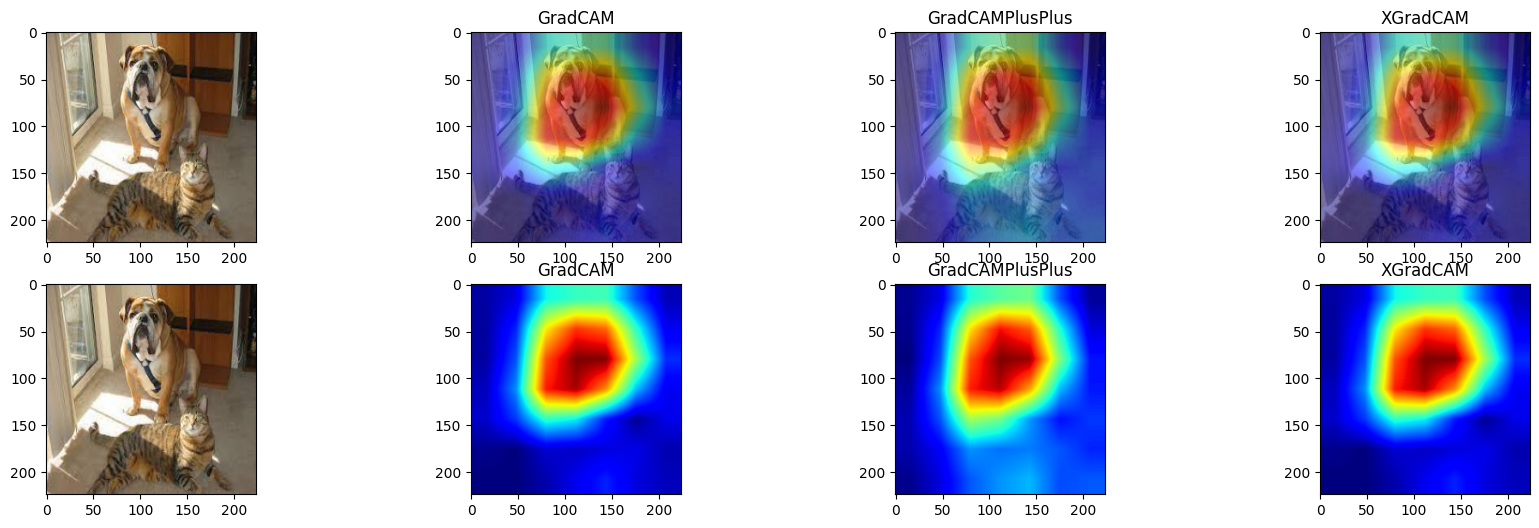

In [ ]:
# GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
cam_methods = [GradCAM, GradCAMPlusPlus, XGradCAM]
num_methods = len(cam_methods)
# read image
img = read_img(filepath)

# plot
rows, columns = 2, num_methods+1
plt.figure(figsize=(num_methods*7, num_methods*2))
plt.subplot(2, num_methods+1, 1)
plt.imshow(img)
plt.subplot(2, num_methods+1, 2+num_methods)
plt.imshow(img)

for i, method in enumerate(cam_methods):
    print(i)
    grayscale_cam, cam_on_img = visualize(img.copy(), method, img_size=img_size)
    method_name = method.__name__
    plt.subplot(rows, columns, i+2)
    plt.imshow(cam_on_img)
    plt.title(method_name)
    plt.subplot(rows, columns, i+3+num_methods)
    plt.title(method_name)
    plt.imshow(grayscale_cam, cmap='jet')
plt.show()

#### Ref: https://github.com/jacobgil/pytorch-grad-cam